In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from __future__ import print_function

import tensorflow as tf

import datetime
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

## Normal Data Preprocessing

In [2]:
# Load the normal data
normal = pd.read_csv("inside_station_normal.csv", sep = ';')
print(normal.shape)

(1558, 13)


In [3]:
# Check the data
normal

,TimeStamp,Relative Time,srcIP,dstIP,srcPort,dstPort,ipLen,MMS Type,MMS Service,Invoke Id,Domain Id,Item Id,Object Class
0,14:24:50.87,0.868153,192.168.1.11,192.168.1.52,49623,102,78,0,1,720163.0,NaN,NaN,9.0
1,14:24:50.88,0.881683,192.168.1.52,192.168.1.11,102,49623,564,1,1,720163.0,NaN,NaN,NaN
2,14:24:52.97,2.976232,192.168.1.12,192.168.1.52,35091,102,78,0,1,137639.0,NaN,NaN,9.0
3,14:24:52.99,2.989919,192.168.1.52,192.168.1.12,102,35091,564,1,1,137639.0,NaN,NaN,NaN
4,14:24:54.26,4.259552,192.168.1.11,192.168.1.61,49621,102,78,0,1,720164.0,NaN,NaN,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,14:41:04.33,974.330396,192.168.1.51,192.168.1.11,102,49622,556,1,1,720745.0,NaN,NaN,NaN
1554,14:41:05.40,975.405759,192.168.1.11,192.168.1.52,49623,102,78,0,1,720746.0,NaN,NaN,9.0
1555,14:41:05.41,975.417950,192.168.1.52,192.168.1.11,102,49623,564,1,1,720746.0,NaN,NaN,NaN
1556,14:41:05.45,975.457751,192.168.1.12,192.168.1.52,35091,102,78,0,1,137832.0,NaN,NaN,9.0


In [4]:
# Looking for null values
normal.isnull().sum()

TimeStamp           0
Relative Time       0
srcIP               0
dstIP               0
srcPort             0
dstPort             0
ipLen               0
MMS Type            0
MMS Service         0
Invoke Id           2
Domain Id        1557
Item Id          1557
Object Class      781
dtype: int64

In [5]:
# Looking for uniques values for each feature
for i in normal.columns:
    print(i)
    print(normal[i].value_counts())
    print("______________________________________")

TimeStamp
14:36:47.59    3
14:36:57.63    3
14:29:35.60    2
14:26:39.74    2
14:30:25.83    2
              ..
14:30:30.86    1
14:30:30.85    1
14:30:27.48    1
14:30:27.47    1
14:41:05.47    1
Name: TimeStamp, Length: 1413, dtype: int64
______________________________________
Relative Time
0.868153      1
642.247653    1
654.645244    1
654.632396    1
653.942849    1
             ..
325.781989    1
323.821030    1
323.808671    1
322.414489    1
975.474871    1
Name: Relative Time, Length: 1558, dtype: int64
______________________________________
srcIP
192.168.1.11    584
192.168.1.52    293
192.168.1.51    293
192.168.1.12    194
192.168.1.61    194
Name: srcIP, dtype: int64
______________________________________
dstIP
192.168.1.11    585
192.168.1.52    293
192.168.1.51    291
192.168.1.12    195
192.168.1.61    194
Name: dstIP, dtype: int64
______________________________________
srcPort
102      780
49623    195
49622    195
49621    194
35091     98
35347     96
Name: srcPort, 

In [6]:
# Looking for duplicate values 
duplicate = normal[normal.duplicated()]
duplicate

,TimeStamp,Relative Time,srcIP,dstIP,srcPort,dstPort,ipLen,MMS Type,MMS Service,Invoke Id,Domain Id,Item Id,Object Class


In [7]:
# replacing NaN values with 'no return'
normal['Domain Id'] = normal['Domain Id'].fillna('no return')
normal['Item Id'] = normal['Item Id'].fillna('no return')
normal['Object Class'] = normal['Object Class'].fillna('no return')

#Droping the timestamp column
normal.drop(columns=['TimeStamp'], inplace = True)

#Droping the redundant column 'srcIP' and 'dstIP'
normal.drop(columns=['srcIP', 'dstIP'], inplace = True)

#Droping the all there other NaN values present
normal_temp = normal.dropna()

In [8]:
normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Relative Time  1558 non-null   float64
 1   srcPort        1558 non-null   int64  
 2   dstPort        1558 non-null   int64  
 3   ipLen          1558 non-null   int64  
 4   MMS Type       1558 non-null   int64  
 5   MMS Service    1558 non-null   int64  
 6   Invoke Id      1556 non-null   float64
 7   Domain Id      1558 non-null   object 
 8   Item Id        1558 non-null   object 
 9   Object Class   1558 non-null   object 
dtypes: float64(2), int64(5), object(3)
memory usage: 121.8+ KB


In [9]:
normal_temp.isnull().sum()

Relative Time    0
srcPort          0
dstPort          0
ipLen            0
MMS Type         0
MMS Service      0
Invoke Id        0
Domain Id        0
Item Id          0
Object Class     0
dtype: int64

In [10]:
normal_temp.shape

(1556, 10)

In [11]:
# One-Hot Encoding of features with discrte and object datatype
normal_temp = pd.get_dummies(normal_temp,columns=["Domain Id","Item Id","Object Class"]) 

In [12]:
normal_temp.shape

(1556, 13)

In [13]:
# Converting pandas df to numpy array
normal_temp = normal_temp.to_numpy()     

In [14]:
# Normalizing the data using MinMaxScaler
scaler = MinMaxScaler()
normal_temp = scaler.fit_transform(normal_temp)

In [15]:
# Creating label for normal network data
final_normal_label = np.zeros(shape=(normal_temp.shape[0]))
for i in range(len(normal_temp)):
    final_normal_label[i] = 0 

In [16]:
final_normal_label

array([0., 0., 0., ..., 0., 0., 0.])

## Attack Data PreProcessing

In [17]:
# Load the attack data

attack = pd.read_csv("inside_substation_attack3.csv", sep = ';')
print(attack.shape)

(2944, 13)


In [18]:
# Check the data
attack

,TimeStamp,Relative Time,srcIP,dstIP,srcPort,dstPort,ipLen,MMS Type,MMS Service,Invoke Id,Domain Id,Item Id,Object Class
0,15:40:51.25,1.576335,192.168.1.11,192.168.1.61,49621,102,78,0,1.0,722892.0,NaN,NaN,9.0
1,15:40:51.26,1.579245,192.168.1.61,192.168.1.11,102,49621,141,1,1.0,722892.0,NaN,NaN,NaN
2,15:40:51.69,2.015327,192.168.1.11,192.168.1.51,49622,102,78,0,1.0,722893.0,NaN,NaN,9.0
3,15:40:51.71,2.030111,192.168.1.51,192.168.1.11,102,49622,556,1,1.0,722893.0,NaN,NaN,NaN
4,15:40:52.93,3.248270,192.168.1.12,192.168.1.51,35347,102,78,0,1.0,138541.0,NaN,NaN,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,15:55:36.10,886.424643,192.168.1.51,192.168.1.11,102,49622,556,1,1.0,723421.0,NaN,NaN,NaN
2940,15:55:37.17,887.493803,192.168.1.12,192.168.1.52,35091,102,78,0,1.0,138713.0,NaN,NaN,9.0
2941,15:55:37.18,887.507047,192.168.1.52,192.168.1.12,102,35091,564,1,1.0,138713.0,NaN,NaN,NaN
2942,15:55:37.51,887.834889,192.168.1.11,192.168.1.52,49623,102,78,0,1.0,723422.0,NaN,NaN,9.0


In [19]:
# Looking for uniques values for each feature
for i in attack.columns:
    print(i)
    print(attack[i].value_counts())
    print("______________________________________")

TimeStamp
15:47:08.04    4
15:46:52.97    4
15:46:53.41    3
15:47:28.53    3
15:47:04.89    3
              ..
15:47:00.73    1
15:47:00.72    1
15:47:00.58    1
15:47:00.57    1
15:55:37.53    1
Name: TimeStamp, Length: 2295, dtype: int64
______________________________________
Relative Time
1.576335      1
408.984677    1
408.199154    1
408.204348    1
408.229839    1
             ..
370.955913    1
370.956382    1
370.971447    1
370.972567    1
887.848021    1
Name: Relative Time, Length: 2944, dtype: int64
______________________________________
srcIP
192.168.1.11    1271
192.168.1.51    1057
192.168.1.52     266
192.168.1.61     177
192.168.1.12     173
Name: srcIP, dtype: int64
______________________________________
dstIP
192.168.1.11    1315
192.168.1.51    1001
192.168.1.52     266
192.168.1.12     185
192.168.1.61     177
Name: dstIP, dtype: int64
______________________________________
srcPort
102      1500
64218     740
49621     177
49622     177
49623     177
35091      89

In [20]:
# Looking for null values

attack.isnull().sum()

TimeStamp           0
Relative Time       0
srcIP               0
dstIP               0
srcPort             0
dstPort             0
ipLen               0
MMS Type            0
MMS Service         4
Invoke Id          60
Domain Id        2445
Item Id          2450
Object Class     1998
dtype: int64

In [21]:
# Looking for duplicate values 
duplicate = attack[attack.duplicated()]
duplicate

,TimeStamp,Relative Time,srcIP,dstIP,srcPort,dstPort,ipLen,MMS Type,MMS Service,Invoke Id,Domain Id,Item Id,Object Class


In [22]:
# replacing NaN values with 'no return'
attack['Domain Id'] = attack['Domain Id'].fillna('no return')
attack['Item Id'] = attack['Item Id'].fillna('no return')
attack['Object Class'] = attack['Object Class'].fillna('no return')

#Droping the timestamp column
attack.drop(columns=['TimeStamp'], inplace = True)

#Droping the redundant column 'srcIP' and 'dstIP'
attack.drop(columns=['srcIP', 'dstIP'], inplace = True)

#Droping the all there other NaN values present
attack_temp = attack.dropna()

In [23]:
attack_temp.isnull().sum()

Relative Time    0
srcPort          0
dstPort          0
ipLen            0
MMS Type         0
MMS Service      0
Invoke Id        0
Domain Id        0
Item Id          0
Object Class     0
dtype: int64

In [24]:
attack_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2884 entries, 0 to 2943
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Relative Time  2884 non-null   float64
 1   srcPort        2884 non-null   int64  
 2   dstPort        2884 non-null   int64  
 3   ipLen          2884 non-null   int64  
 4   MMS Type       2884 non-null   int64  
 5   MMS Service    2884 non-null   float64
 6   Invoke Id      2884 non-null   float64
 7   Domain Id      2884 non-null   object 
 8   Item Id        2884 non-null   object 
 9   Object Class   2884 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 247.8+ KB


In [25]:
# One-Hot Encoding of features with discrte and object datatype
attack_temp = pd.get_dummies(attack_temp,columns=["Domain Id","Item Id","Object Class"]) 

In [26]:
attack_temp.shape

(2884, 121)

In [27]:
#Performing PCA for dimension reduction process to reduce the dimension from 121 to 13

from sklearn.decomposition import PCA

pca = PCA(n_components=13)
attack_temp = pca.fit_transform(attack_temp)

In [28]:
attack_temp

array([[ 4.39794804e+05, -3.50156156e+04, -9.90539990e+02, ...,
         1.19907700e-03, -6.35292375e-03,  3.44510053e-03],
       [ 4.39794806e+05,  3.50146442e+04, -9.91452471e+02, ...,
        -4.14600445e-03,  5.89854851e-03,  9.84634317e-03],
       [ 4.39795796e+05, -3.50163227e+04, -9.91257244e+02, ...,
         1.19769664e-03, -6.34923889e-03,  3.44207583e-03],
       ...,
       [-1.44227634e+05,  2.47419215e+04,  1.59943511e+04, ...,
        -1.02556933e-02,  5.40509678e-02, -3.01076404e-02],
       [ 4.40324824e+05, -3.50170297e+04, -9.95489450e+02, ...,
         4.87693631e-04, -5.79554417e-03, -2.65485117e-05],
       [ 4.40324839e+05,  3.50174748e+04, -9.94219598e+02, ...,
         6.79305052e-04,  6.31329434e-03, -8.51301953e-03]])

In [29]:
attack_temp.shape

(2884, 13)

In [30]:
# Normalizing the data using MinMaxScaler
scaler = MinMaxScaler()
attack_temp = scaler.fit_transform(attack_temp)

In [31]:
# Creating label for attack network data
final_attack_label = np.zeros(shape=(attack_temp.shape[0]))
for i in range(len(attack_temp)):
    final_attack_label[i] = 1  

In [32]:
# mergeing normal and attack dataset
final = np.concatenate((normal_temp, attack_temp), axis=0)

In [33]:
final.shape

(4440, 13)

In [34]:
# merging the labels dataset
final_labels = np.concatenate((final_normal_label, final_attack_label), axis=0)

In [35]:
final_labels.shape

(4440,)

In [36]:
#shuffle the data with respect to their labels

idx = np.random.permutation(len(final))
X,y = final[idx], final_labels[idx]

In [37]:
# Spliting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [38]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3552, 13)
(888, 13)
(3552,)
(888,)


In [39]:
# sequential model 
model = Sequential()

model.add(Dense(32, activation='relu',input_shape = (13,)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [40]:
# One Hot Encoding the labels
num_class = 2

y_train = keras.utils.to_categorical(y_train, num_class)
y_test = keras.utils.to_categorical(y_test, num_class)

y_train[150]


array([0., 1.], dtype=float32)

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________


In [42]:
# compile the model using RMSprop optimizer
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(lr=0.001),
             metrics=['accuracy'])

In [43]:
# training the model
batch_size = 128
epochs = 10

his = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data=(X_test, y_test))

Epoch 1/10
28/28 [==============================] - 0s 5ms/step - loss: 0.5339 - accuracy: 0.7500 - val_loss: 0.3381 - val_accuracy: 0.9865
Epoch 2/10
28/28 [==============================] - 0s 2ms/step - loss: 0.2685 - accuracy: 0.9541 - val_loss: 0.1371 - val_accuracy: 1.0000
Epoch 3/10
28/28 [==============================] - 0s 2ms/step - loss: 0.1236 - accuracy: 0.9842 - val_loss: 0.0462 - val_accuracy: 1.0000
Epoch 4/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0509 - accuracy: 0.9972 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 5/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9986 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 6/10
28/28 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.9992 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/10
28/28 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 0.9992 - val_loss: 7.6639e-04 - val_accuracy: 1.0000
Epoch 8/10
28/28

In [44]:
print(his.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


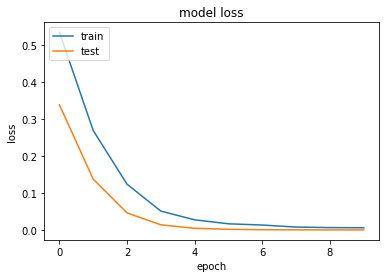

In [45]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

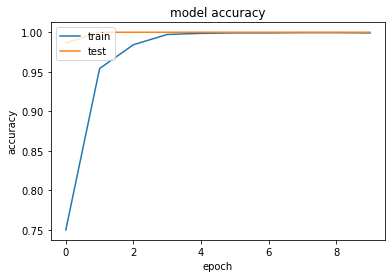

In [46]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
# Prediction for y_test
y_hat = model.predict(X_test)
y_hat[y_hat <= 0.5] = 0
y_hat[y_hat > 0.5] = 1

In [48]:
# Classification report on the model 
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       306
           1       1.00      1.00      1.00       582

   micro avg       1.00      1.00      1.00       888
   macro avg       1.00      1.00      1.00       888
weighted avg       1.00      1.00      1.00       888
 samples avg       1.00      1.00      1.00       888



In [49]:
# Model Accuracy
accuracy_score(y_test, y_hat)

1.0